In [142]:
import sliderule
import xarray as xr
import rioxarray
import pystac_client
import odc.stac
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#rom esda.moran import Moran
from datetime import timedelta
import misc.sr_wrapper
import misc.stac_helper
import coincident
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
gf_flights = gpd.read_file("/home/jehayes/gda_final/ATL06_LaserLottery/test_data/wesm_2021_bboxes_30d_esa.geojson")

In [65]:
atl06_items = misc.stac_helper.get_atl06_stac(gf_flights.iloc[0])
gf_atl06_stac = misc.stac_helper.to_geopandas(atl06_items[0].item_collection())

In [66]:
gf_atl06_stac

,assets,bbox,collection,geometry,id,links,stac_extensions,stac_version,type,datetime,end_datetime,start_datetime,dayofyear
0,{'20/ATL06_20210620004445_13321102_006_01': {'...,"{'xmin': -124.93169, 'ymin': 35.444, 'xmax': -...",ATL06_006,"POLYGON ((-124.71118 59.54054, -124.93169 59.5...",SC:ATL06.006:272421108,[{'href': 'https://cmr.earthdata.nasa.gov/stac...,[],1.1.0,Feature,2021-06-20 00:46:49.870000+00:00,2021-06-20 00:53:15.373000+00:00,2021-06-20 00:46:49.870000+00:00,171
1,{'24/ATL06_20210624003626_00061202_006_01': {'...,"{'xmin': -125.61423, 'ymin': 35.82996, 'xmax':...",ATL06_006,"POLYGON ((-125.39382 59.54551, -125.61423 59.5...",SC:ATL06.006:272416853,[{'href': 'https://cmr.earthdata.nasa.gov/stac...,[],1.1.0,Feature,2021-06-24 00:38:44.185000+00:00,2021-06-24 00:44:55.763000+00:00,2021-06-24 00:38:44.185000+00:00,175
2,{'26/ATL06_20210626124356_00441206_006_01': {'...,"{'xmin': -123.56884, 'ymin': 38.12829, 'xmax':...",ATL06_006,"POLYGON ((-120.15698 59.53431, -120.37752 59.5...",SC:ATL06.006:272422736,[{'href': 'https://cmr.earthdata.nasa.gov/stac...,[],1.1.0,Feature,2021-06-26 12:43:55.642000+00:00,2021-06-26 12:49:31.271000+00:00,2021-06-26 12:43:55.642000+00:00,177
3,{'18/ATL06_20210718232050_03871202_006_01': {'...,"{'xmin': -124.57766, 'ymin': 33.67947, 'xmax':...",ATL06_006,"POLYGON ((-124.35715 59.54551, -124.57766 59.5...",SC:ATL06.006:272537272,[{'href': 'https://cmr.earthdata.nasa.gov/stac...,[],1.1.0,Feature,2021-07-18 23:22:35.898000+00:00,2021-07-18 23:29:21.180000+00:00,2021-07-18 23:22:35.898000+00:00,199


In [70]:
gf_atl06_points = misc.sr_wrapper.get_atl06_default(
    gf_atl06_stac,
    window_start = atl06_items[1],
    window_end = atl06_items[2],
    aoi_geometry= gf_flights.iloc[0].geometry
)

In [71]:
print(gf_atl06_points.shape)
gf_atl06_points.head(2)

(10098, 16)


,gt,cycle,pflags,y_atc,n_fit_photons,dh_fit_dx,w_surface_window_final,h_mean,region,h_sigma,segment_id,spot,rms_misfit,x_atc,rgt,geometry
time,,,,,,,,,,,,,,,,
2021-06-20 00:49:11.660015872,60,11,0,4526.651367,10,-0.075189,3.0,971.076302,2,0.056204,244265,1,0.167967,4898345.0,1332,POINT (-122.2982 44.00489)
2021-06-20 00:49:11.665652480,60,11,0,4526.632812,20,-0.079606,3.0,967.683064,2,0.032158,244267,1,0.137293,4898385.0,1332,POINT (-122.29825 44.00525)


In [91]:
gf_atl06_points = misc.sr_wrapper.get_atl06_default(
    gf_atl06_stac,
    window_start = atl06_items[1],
    window_end = atl06_items[2],
    aoi_geometry= gf_flights.iloc[0].geometry,
    include_3dep=True,
    include_worldcover=True,
)

In [92]:
print(gf_atl06_points.shape)
gf_atl06_points.head(2)

(10098, 24)


,gt,cycle,pflags,y_atc,n_fit_photons,dh_fit_dx,w_surface_window_final,h_mean,region,h_sigma,...,rgt,geometry,3dep.file_id,3dep.value,3dep.flags,3dep.time,worldcover.file_id,worldcover.value,worldcover.flags,worldcover.time
time,,,,,,,,,,,,,,,,,,,,,
2021-06-20 00:49:11.660015872,60,11,0,4526.651367,10,-0.075189,3.0,971.076302,2,0.056204,...,1332,POINT (-122.2982 44.00489),[8589934596],[nan],[0],[1335070886.0],8589934592,10.0,0,1309046418.0
2021-06-20 00:49:11.665652480,60,11,0,4526.632812,20,-0.079606,3.0,967.683064,2,0.032158,...,1332,POINT (-122.29825 44.00525),[8589934596],[nan],[0],[1335070886.0],8589934592,10.0,0,1309046418.0


In [ ]:
gf_atl06_points['3dep.value']

time
2021-06-20 00:49:11.660015872                 [nan]
2021-06-20 00:49:11.665652480                 [nan]
2021-06-20 00:49:11.857341952                 [nan]
2021-06-20 00:49:11.860166144                 [nan]
2021-06-20 00:49:12.389425408    [840.733565976761]
                                        ...        
2021-07-18 23:25:22.982358016           1063.959745
2021-07-18 23:25:22.985181696           1063.307348
2021-07-18 23:25:22.987998464           1061.771163
2021-07-18 23:25:22.990805504           1060.450065
2021-07-18 23:25:22.993608960           1058.653383
Name: 3dep.value, Length: 10098, dtype: object

In [ ]:
np.unique(gf_atl06_points['worldcover.value'])

array([10.0, 30.0, array([40.]), 50.0, 60.0, 80.0], dtype=object)

In [98]:
# First convert any list-like values to floats in '3dep.value'
gf_atl06_points['3dep.value'] = gf_atl06_points['3dep.value'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)
# Create forest GDF with valid 3DEP values and forest landcover
gf_atl06_forest = gf_atl06_points[
    (gf_atl06_points['3dep.value'].notna()) & 
    (gf_atl06_points['worldcover.value'] == 10.0)
]

In [115]:
print("Reference Ground Tracks: {}".format(gf_atl06_forest["rgt"].unique()))
print("Cycles: {}".format(gf_atl06_forest["cycle"].unique()))
print("Received {} elevations".format(gf_atl06_forest.shape[0]))
gf_atl06_forest.head(2)

Reference Ground Tracks: [1332    6   44  387]
Cycles: [11 12]
Received 3870 elevations


,gt,cycle,pflags,y_atc,n_fit_photons,dh_fit_dx,w_surface_window_final,h_mean,region,h_sigma,...,rgt,geometry,3dep.file_id,3dep.value,3dep.flags,3dep.time,worldcover.file_id,worldcover.value,worldcover.flags,worldcover.time
time,,,,,,,,,,,,,,,,,,,,,
2021-06-20 00:49:12.389425408,60,11,0,4516.310059,16,0.128564,3.334943,840.912305,2,0.051492,...,1332,POINT (-122.30429 44.0514),[8589934596],840.733566,[0],[1335070886.0],8589934592,10.0,0,1309046418.0
2021-06-20 00:49:12.392237824,60,11,0,4516.279297,24,0.128546,3.334498,843.495238,2,0.031352,...,1332,POINT (-122.30432 44.05158),[8589934596],844.005697,[0],[1335070886.0],8589934592,10.0,0,1309046418.0


In [114]:
np.unique(gf_atl06_forest['gt'])

array([10, 20, 30, 40, 50, 60], dtype=uint8)

In [119]:
np.unique(gf_atl06_forest['region'])

array([2, 6], dtype=uint8)

In [85]:
gf_wesm = coincident.search.wesm.load_by_fid(fids=gf_flights.iloc[[0]].fid.values).to_crs(gf_atl06_points.crs)

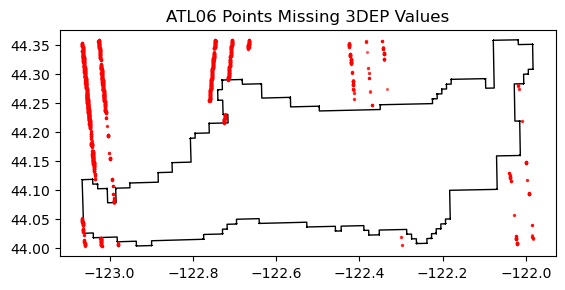

In [ ]:
f, ax = plt.subplots()
gf_wesm.plot(ax=ax, facecolor="none", edgecolor='black')
nan_points = gf_atl06_points[gf_atl06_points['3dep.value'].isna()]
nan_points.plot(ax=ax, color='red', markersize=2, alpha=0.5)
plt.title('ATL06 Points Missing 3DEP Values');

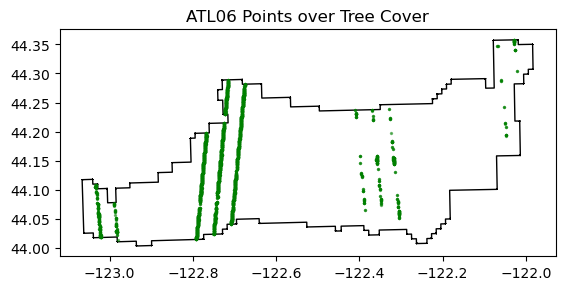

In [100]:
f, ax = plt.subplots()
gf_wesm.plot(ax=ax, facecolor="none", edgecolor='black')
gf_atl06_forest.plot(ax=ax, color='green', markersize=2, alpha=0.5)
plt.title('ATL06 Points over Tree Cover');

In [137]:
gf_atl06_forest["elev_diff"] = gf_atl06_forest["h_mean"] - gf_atl06_forest["3dep.value"]

/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


/tmp/ipykernel_73181/255133691.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


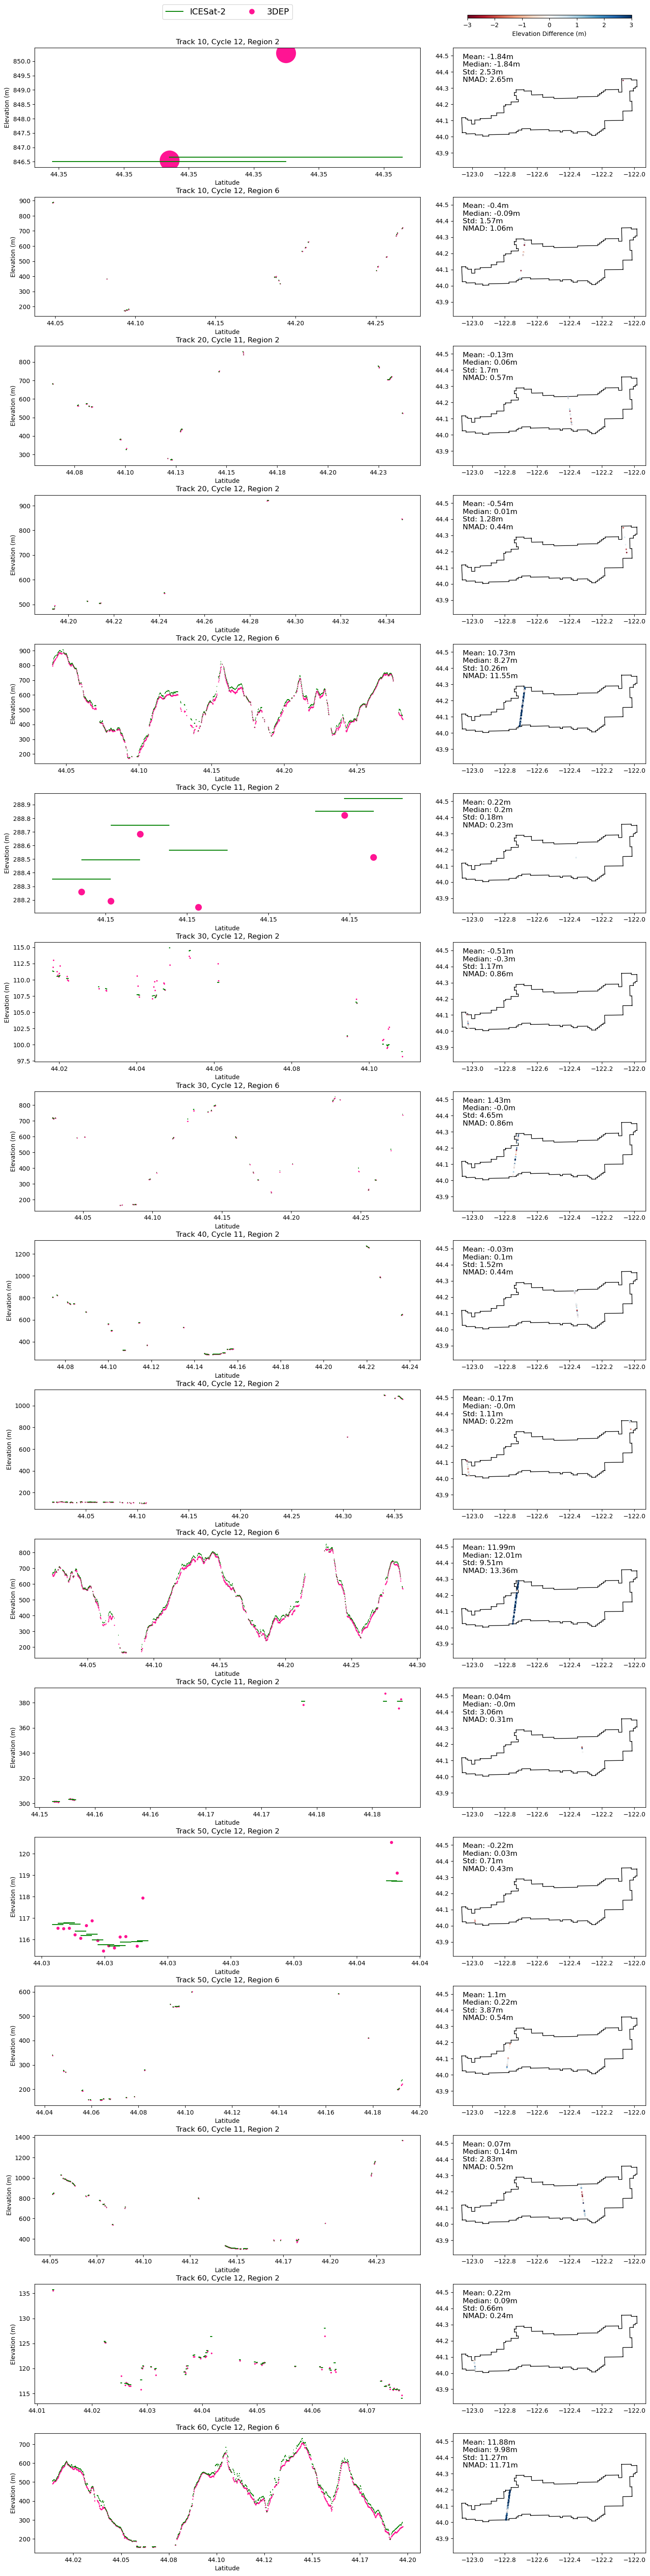

In [152]:
track_groups = gf_atl06_forest.groupby(["gt", "cycle", "region"])
n_groups = len(track_groups)

fig = plt.figure(figsize=(15, 4*n_groups))
gs = GridSpec(n_groups, 2, width_ratios=[2, 1])

# Create a colorbar axis above the right column
cbar_ax = fig.add_axes([.715, 0.86, 0.25, 0.001]) 
norm = plt.Normalize(vmin=-3, vmax=3)
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
plt.colorbar(sm, cax=cbar_ax, orientation='horizontal', label='Elevation Difference (m)')

for idx, (name, group) in enumerate(track_groups):
    ax1 = fig.add_subplot(gs[idx, 0])
    
    meters_to_degrees_40m = 40 / 111000
    y_coords = [geom.y for geom in group.geometry]
    
    # Create horizontal lines for ICESat-2 elevations
    for lat, elev in zip(y_coords, group['h_mean']):
        ax1.hlines(y=elev, xmin=lat-meters_to_degrees_40m/2, xmax=lat+meters_to_degrees_40m/2,
                  colors='green', label='ICESat-2' if (idx==0 and lat==y_coords[0]) else "")
    
    # Calculate dynamic marker size based on x-axis range
    x_range = max(y_coords) - min(y_coords)
    marker_size = (meters_to_degrees_40m / x_range) * 500
    
    # Plot 3DEP points with dynamic sizing
    ax1.scatter(y_coords, group['3dep.value'],
               marker='o',
               c='deeppink',
               alpha=1.0,
               s=marker_size,
               label='3DEP' if idx==0 else "")
    
    ax1.set_xlabel('Latitude')
    ax1.set_ylabel('Elevation (m)')
    ax1.set_title(f'Track {name[0]}, Cycle {name[1]}, Region {name[2]}')
    
    # Format x-axis to show two decimal places
    ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

    # For the legend, we can control marker size specifically for the legend:
    if idx == 0:
        legend_elements = [
            Line2D([0], [0], color='green', label='ICESat-2'),
            Line2D([0], [0], marker='o', color='w', label='3DEP',
                markerfacecolor='deeppink', markersize=10)
        ]
        ax1.legend(handles=legend_elements, bbox_to_anchor=(0.5, 1.3), 
                loc='center', ncol=2, fontsize=14)

    
    # Enhanced map plot with elevation differences
    ax2 = fig.add_subplot(gs[idx, 1])
    gf_wesm.plot(ax=ax2, facecolor="none", edgecolor='black')
    group.plot(ax=ax2, column='elev_diff', cmap='RdBu',
              vmin=-3, vmax=3, alpha=0.7, markersize=2)
    ax2.set_title('')
    mean_diff = round(group['elev_diff'].mean(), 2)
    median_diff = round(group['elev_diff'].median(), 2)
    std_diff = round(group['elev_diff'].std(), 2)
    nmad = round(1.4826 * np.median(np.abs(group['elev_diff'] - median_diff)), 2)

    # Add stats text
    stats_text = f'Mean: {mean_diff}m\nMedian: {median_diff}m\nStd: {std_diff}m\nNMAD: {nmad}m'
    ax2.text(0.05, 0.95, stats_text, 
            transform=ax2.transAxes,
            fontsize=12,
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax2.axis('equal')

plt.tight_layout()
# Adjust layout to accommodate the colorbar and legend
plt.subplots_adjust(top=0.85)